In [54]:
import obspy
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from obspy.core.utcdatetime import UTCDateTime as utc
from tqdm import tqdm

import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style("ticks")

from obspy.clients.fdsn import Client
client = Client("IRIS")

## arrival shifting

In [8]:
picktime = utc("2002-01-01T17:06:22.86")
starttime = picktime - 2
endtime = picktime + 3

In [21]:
# day-long + trim
s1 = obspy.read("./OBC.UW.2002.001"); 
s1 = s1.trim(starttime = starttime, endtime = endtime)

# IRIS
s2 = client.get_waveforms("UW", "OBC", "--", "EHZ", 
             starttime = starttime, endtime = endtime)

# read short
s3 = obspy.read("./OBC.UW.2002.001",
             starttime = starttime, endtime = endtime, 
             nearest_sample=False)

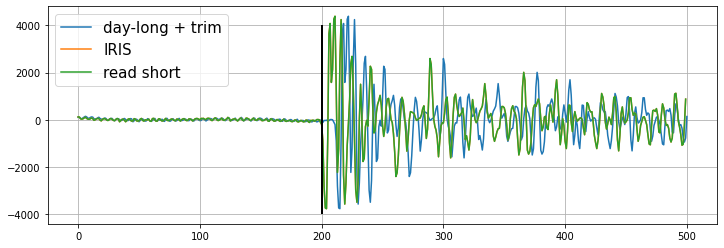

In [22]:
plt.figure(figsize = (12,4))
plt.plot(s1[0].data, label = "day-long + trim")
plt.plot(s2[0].data, label = "IRIS")
plt.plot(s3[0].data, label = "read short")
plt.vlines(200, -4000, 4000, 'k', zorder = 90, linewidth = 2)
plt.grid(True)
plt.legend(fontsize = 15)
plt.savefig("./waveform.pdf", bbox_inches = 'tight')

## propagating of the shifting

In [63]:
starttime = utc("2002-03-02T00:00:00")
# day-long + trim
s1 = obspy.read("./OBC.UW.2002.061"); 

dt = 0 # in seconds
drift_EH = []
for i in range(24):
    s1t = s1.copy().trim(starttime = starttime + dt, 
                   endtime = starttime + 60 + dt)
    s2 = client.get_waveforms("UW", "OBC", "--", "EHZ", 
             starttime = starttime + dt - 1, 
             endtime = starttime + 60 + dt + 1)
    xcorr = scipy.signal.correlate(s1t[0].data, s2[0].data, mode= 'valid')
    drift_EH.append(np.argmax(xcorr) - 100)
    dt += 60*60

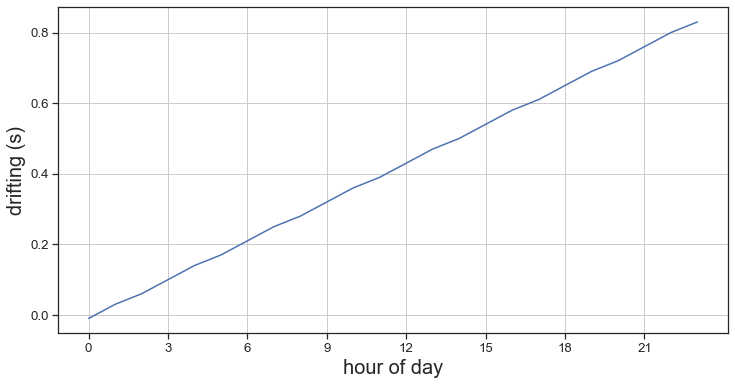

In [71]:
plt.figure(figsize = (12, 6))
plt.plot(np.array(drift_EH)/100, label = "EH")
# plt.plot(np.array(drift_HH)/100, label = "HH")
_ = plt.xticks(np.arange(0, 24, 3))
plt.ylabel("drifting (s)", fontsize = 20)
plt.xlabel("hour of day", fontsize = 20)
plt.grid(True)
# plt.legend()
plt.savefig("./timing_error_drifting.pdf", bbox_inches = 'tight')